## Generate synthetic Anomalies

trying to replicate the synthethic anomalies from the LOE paper

https://arxiv.org/abs/2202.08088
"""
Since the MVTEC training set contains
no anomalies, we contaminate it with artificial anomalies
that we create by adding zero-mean Gaussian noise to the
features of test set anomalies. We use a large variance for
the additive noise (equal to the empirical variance of the
anomalous features) to reduce information leakage from the
test set into the training set.
"""


$$X = \text{Wideresnet or other embeddings},A = \text{Real Anomalies}, S = \text{Synthethic Anomalies}$$
Assumed A is multivariate Gauss (which they are most probably not):
$$\mathbf{A} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}_{A})$$
They assume noise $\mathbf{\epsilon}$ to be added to the anomalies of the testset which increases the variance of S:
$$\mathbf{\epsilon} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{\Sigma_{A}})$$
Therefore:
$$\mathbf{S} \sim \mathcal{N}(\boldsymbol{\mu},  \boldsymbol{\Sigma_{A}} + \boldsymbol{\Sigma_{A}})$$

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import seaborn as sns

# FILEPATH: /home/bule/projects/MVTec_Visualizer/workspace/mvtec_syntheticAnomalies.ipynb
import sys
sys.path.append('..')
from utils.helpers import *
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [2]:
# set the embeddings & read it 
FILENAME =  'MVTEC_CLIP_embeddings_df'#'MVTEC_CLIP_embeddings_df'#'MVTEC_WIDERESNET50_3thBlock_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

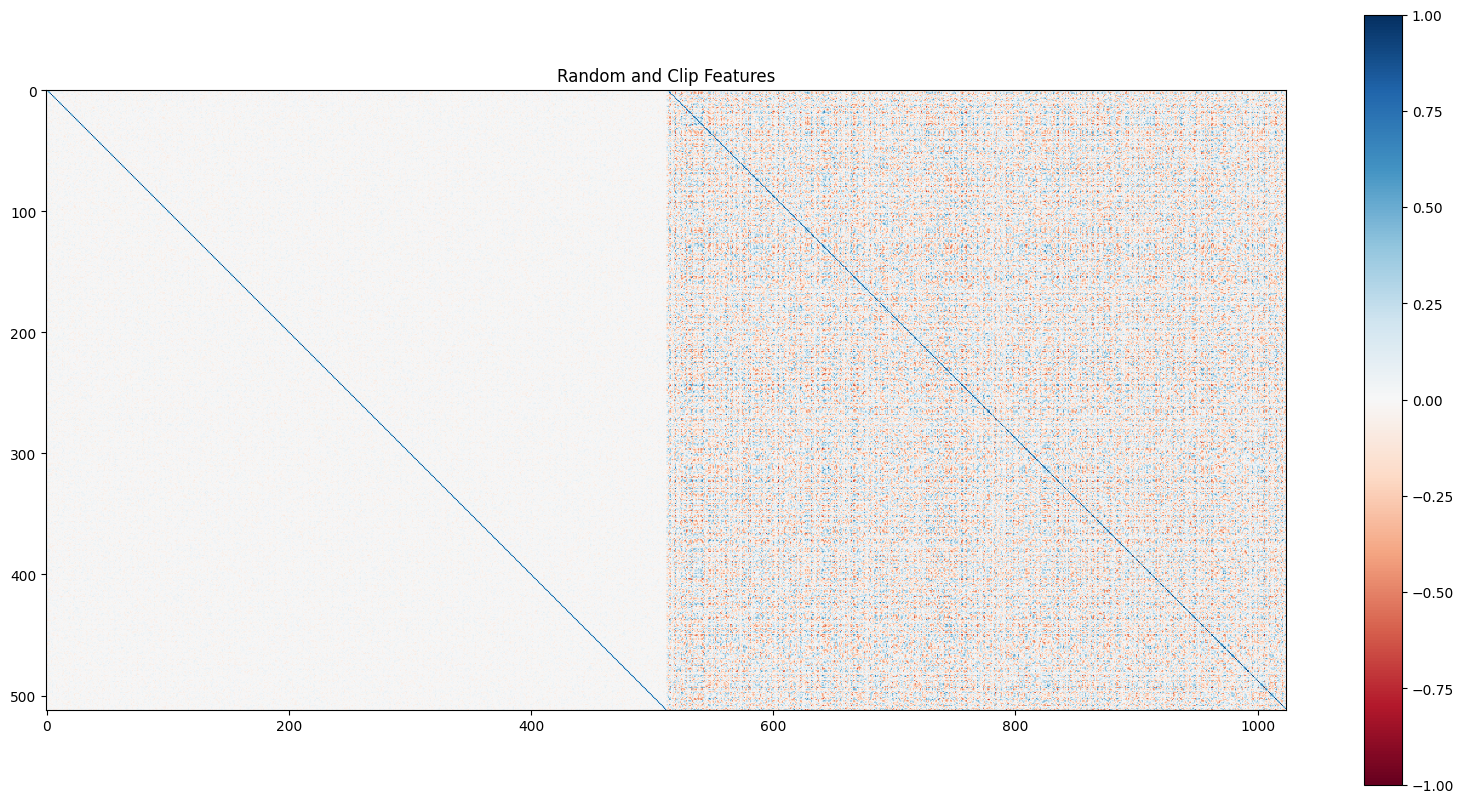

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Generate 512 random features
data = torch.randn(1000, 512)

# Calculate the correlation matrix
correlation_matrix = torch.corrcoef(data.t())  # Transpose to row-wise features
correlation_matrix_numpy = correlation_matrix.numpy()

# Generate 512 clip features
data_clip = torch.Tensor(df.to_numpy())

# Calculate the correlation matrix
correlation_matrix_clip = torch.corrcoef(data_clip.t())  # Transpose to row-wise features
correlation_matrix_clip_numpy = correlation_matrix_clip.numpy()

# Concatenate the two correlation matrices side by side
combined_correlation_matrix = np.concatenate((correlation_matrix_numpy,
                                                 correlation_matrix_clip_numpy), axis=1)

# Plot the combined correlation matrix
plt.figure(figsize=(20, 10))
plt.imshow(combined_correlation_matrix, plt.cm.RdBu, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Random and Clip Features")
plt.show()




In [4]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'scratch','squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'combined','contamination', 'crack', 'faulty_imprint', 'pill_type','scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck','thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil','rough'],
    'toothbrush': ['defective'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'combined','fabric_border', 'fabric_interior','split_teeth','rough', 'squeezed_teeth']}


# change class here
category='metal_nut'
#number of synthetic anomalies to create
n_synthetic=30

synthetic_sampling_method='additive_0_mean_gauss' #  or multivariate_gauss
#synthetic_sampling_method='multivariate_gauss' #  or multivariate_gauss

# create synthetic anomalies
combined_samples,labels,class_list= create_synset_for_class(category,df,n_synthetic, sampler=synthetic_sampling_method)

info={'filename':FILENAME,'category':category,'n_synthetic':n_synthetic,'sampler':synthetic_sampling_method}

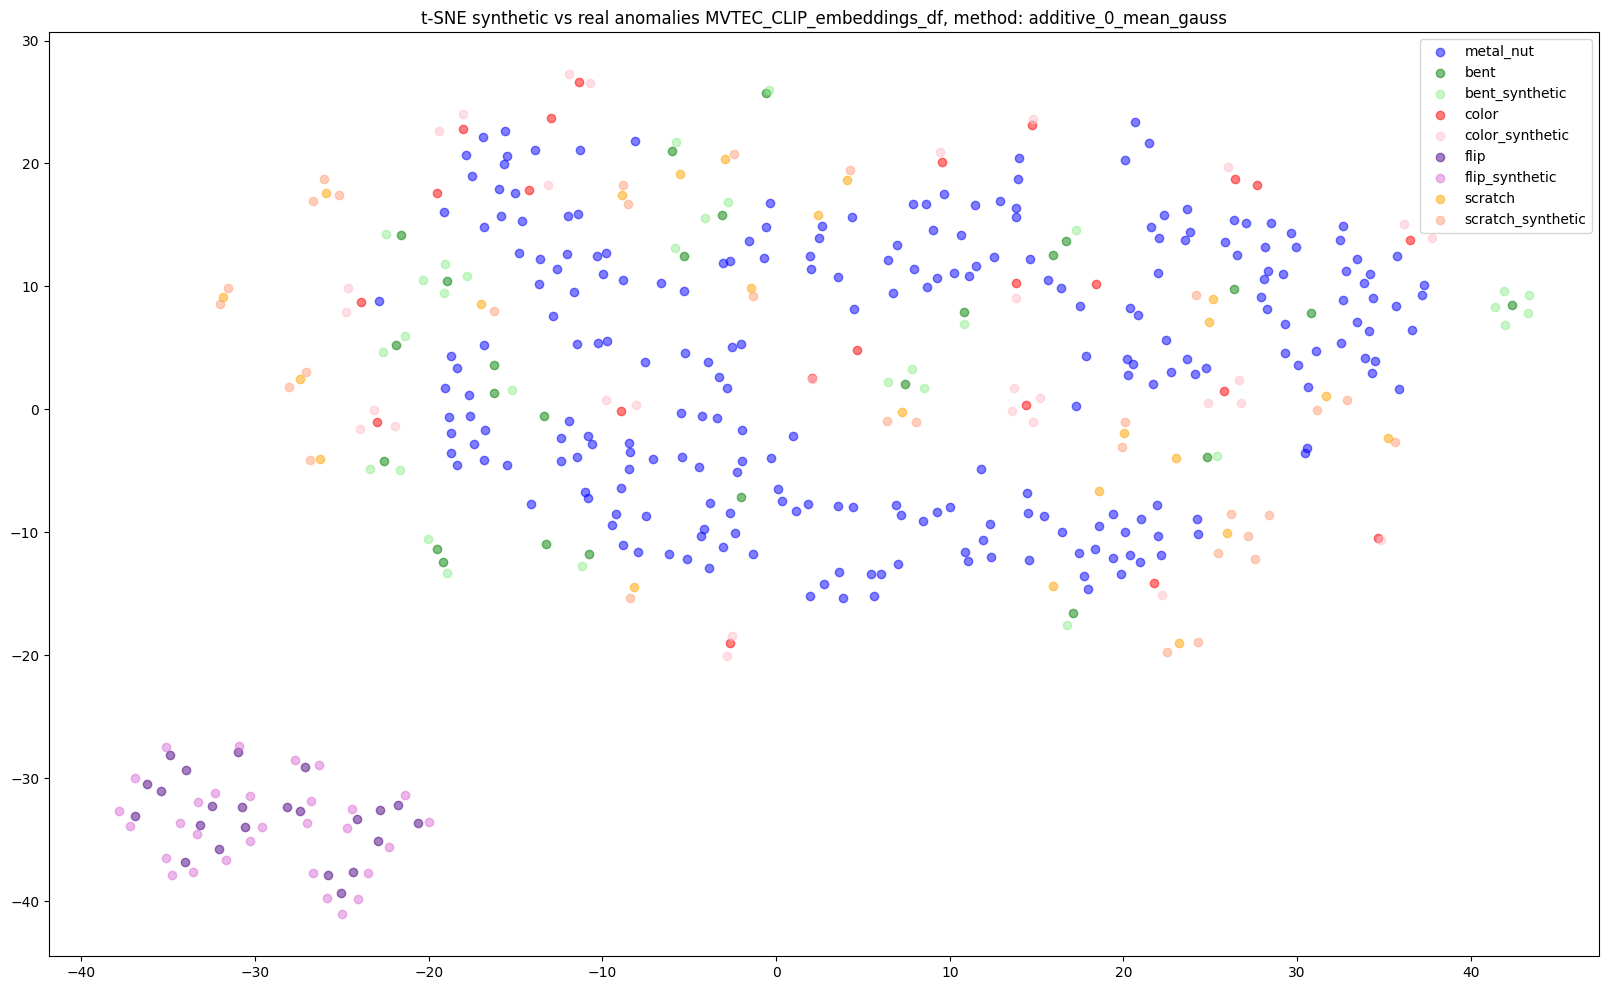

In [5]:
for _ in range(1):
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    reduced_data = tsne.fit_transform(combined_samples)
    colors = ['blue', 'green', 'lightgreen', 'red', 'pink', 'indigo', 'orchid', 'orange', 'lightsalmon', 'purple', 'lavender', 'saddlebrown', 'wheat', 'black', 'gray','olive', 'palegreen']
    jitter_amount = 0.3
    # Plotting
    plt.figure(figsize=(20, 12))
    for i in range(len(class_list)):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])
        
    plt.title(f"t-SNE synthetic vs real anomalies {FILENAME}, method: {info['sampler']}")
    plt.legend()
    plt.show()

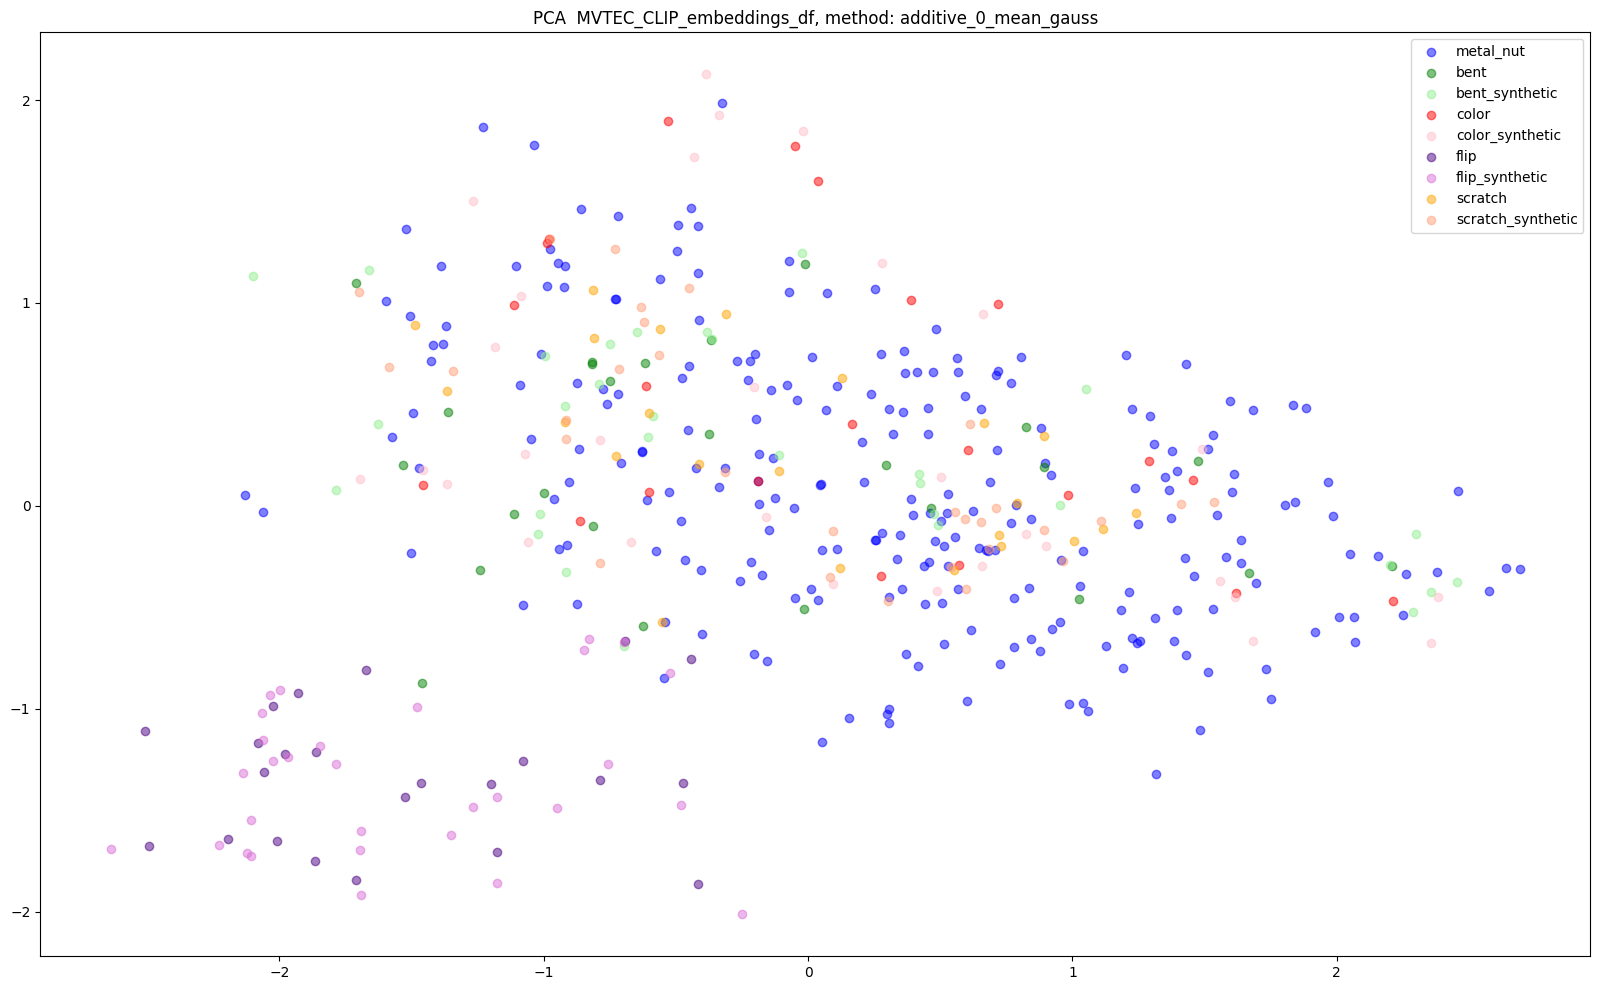

In [6]:
# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_samples)

# Plotting
plt.figure(figsize=(20, 12))
# Iterate over each unique label to plot them separately
for i in range(len(class_list)):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5, color=colors[i])

plt.title(f"PCA  {FILENAME}, method: {info['sampler']}")
plt.legend()
plt.show()


# Model based Reconstruction

- learning normal state and detect deviation

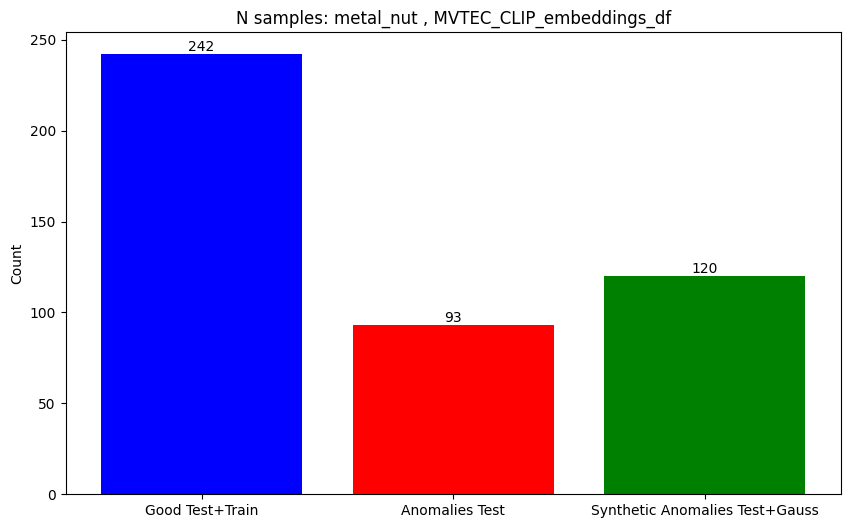

In [7]:
# filter for the synthetic and real anomalies
normals=combined_samples[labels==0]
anomalies=combined_samples[(labels % 2 != 0) & (labels != 0)] 
synthetic_anomalies=combined_samples[(labels % 2 == 0) & (labels != 0)] 
# plot it
plot_data_distribution(normals, anomalies, synthetic_anomalies,info=info)

## PCA

### "train" on normal data

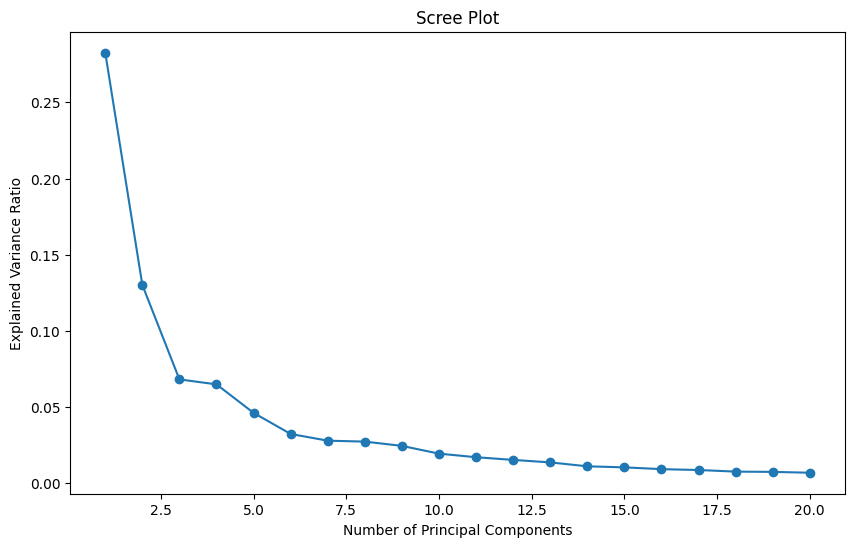

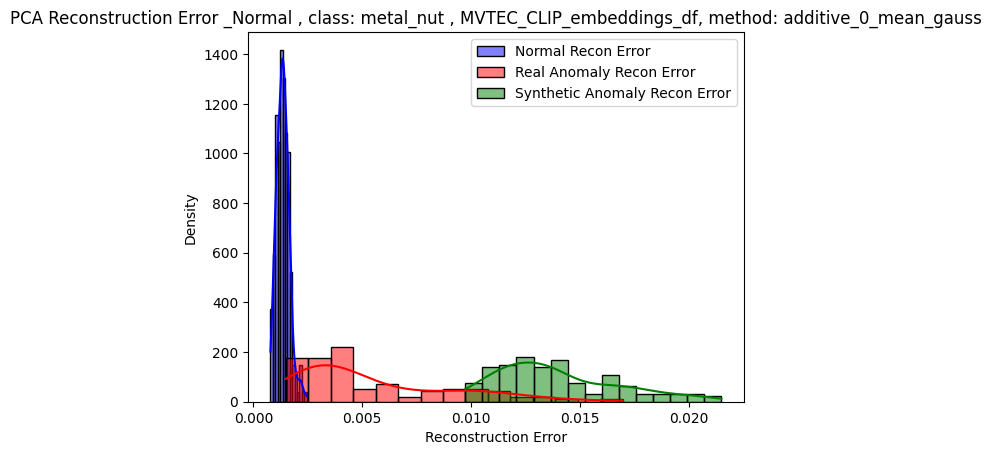

In [17]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)

n_dims=20
pca = PCA(n_components=n_dims)  # Reduce dimensionality

# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons

# Normal data
reduced_normal_data = pca.fit_transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
#Real Anomalies 
reduced_anomaly_data = pca.transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))

#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))

plt.figure(figsize=(10, 6))
bins_number = 15


plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o'),plt.title('Scree Plot'),plt.xlabel('Number of Principal Components'),plt.ylabel('Explained Variance Ratio'),plt.show()



# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _Normal , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

### "train" on anomalous data

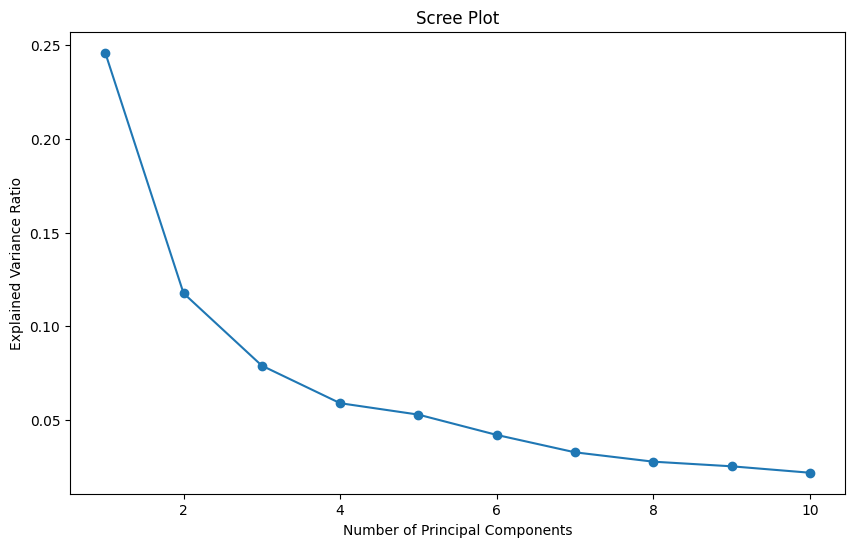

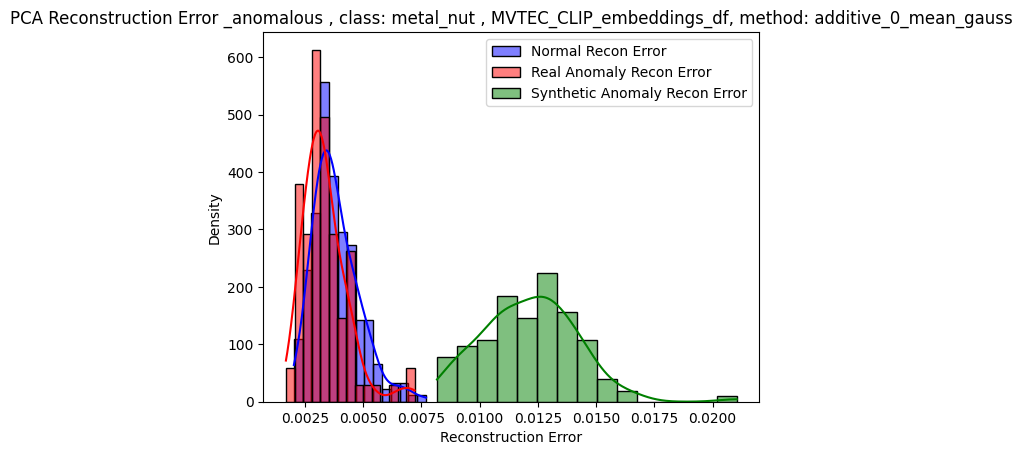

In [15]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)
n_dims=10
pca = PCA(n_components=n_dims)  # Reduce dimensionality

# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons

#Real Anomalies 
reduced_anomaly_data = pca.fit_transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))
    
# Normal data
reduced_normal_data = pca.transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))

plt.figure(figsize=(10, 6))
bins_number = 15



plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o'),plt.title('Scree Plot'),plt.xlabel('Number of Principal Components'),plt.ylabel('Explained Variance Ratio'),plt.show()

# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _anomalous , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

### "train" on synthethic anomalous data

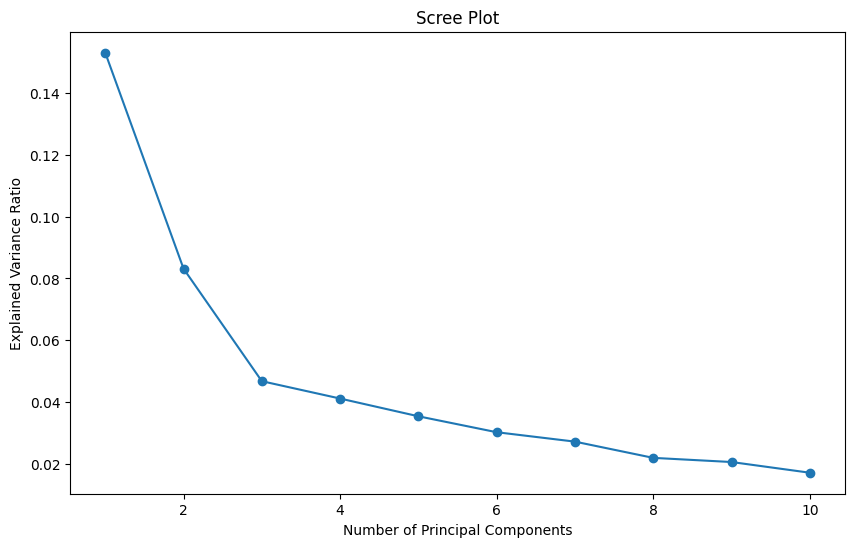

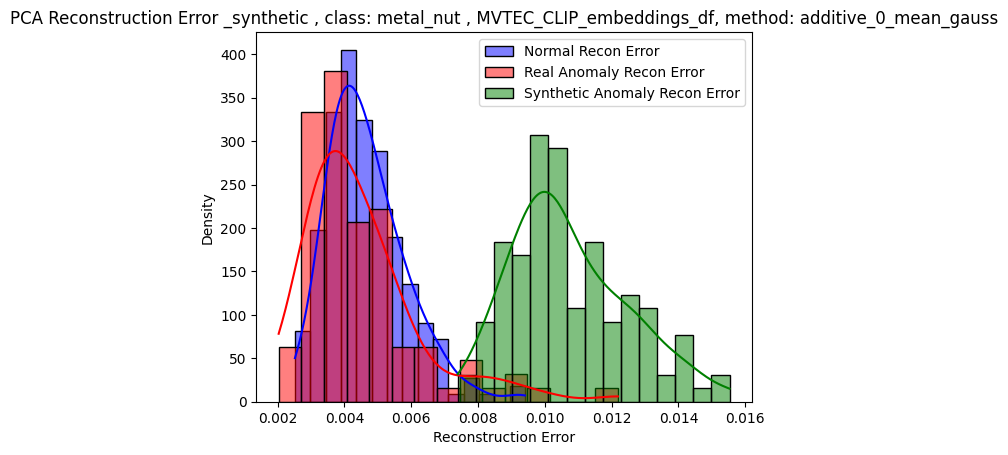

In [10]:
normal_data = np.array(normals)
anomalies = np.array(anomalies)
synthetic_anomalies = np.array(synthetic_anomalies)
n_dims=10
pca = PCA(n_components=n_dims)  # Reduce dimensionalit
# empty recons 
normal_recon_error,anomaly_recon_error,synthetic_anomaly_recon_error = [],[],[]  #  empty recons


#Synthetic Anomalies 
reduced_synthetic_anomaly_data = pca.fit_transform(synthetic_anomalies)
for i in range(len(reduced_synthetic_anomaly_data)):
    reconstructed_synthetic_anomaly = pca.inverse_transform(reduced_synthetic_anomaly_data[i, :])
    synthetic_anomaly_recon_error.append(mean_squared_error(synthetic_anomalies[i], reconstructed_synthetic_anomaly))
    
#Real Anomalies 
reduced_anomaly_data = pca.transform(anomalies)  
for i in range(len(reduced_anomaly_data)):
    reconstructed_anomaly = pca.inverse_transform(reduced_anomaly_data[i, :])
    anomaly_recon_error.append(mean_squared_error(anomalies[i], reconstructed_anomaly))
    
# Normal data
reduced_normal_data = pca.transform(normal_data)  # Transform normal data
for i in range(len(reduced_normal_data)):
    reconstructed_normal = pca.inverse_transform(reduced_normal_data[i, :])
    normal_recon_error.append(mean_squared_error(normal_data[i], reconstructed_normal))
    
plt.figure(figsize=(10, 6))
bins_number = 15


plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o'),plt.title('Scree Plot'),plt.xlabel('Number of Principal Components'),plt.ylabel('Explained Variance Ratio'),plt.show()


# Plot distribution of reconstruction error
sns.histplot(normal_recon_error, label='Normal Recon Error', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_recon_error, label='Real Anomaly Recon Error', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_recon_error, label='Synthetic Anomaly Recon Error', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'PCA Reconstruction Error _synthetic , class: {category} , {FILENAME}, method: {info["sampler"]}'),plt.xlabel('Reconstruction Error'),plt.ylabel('Density')
plt.legend()
plt.show()

## Autoencoder

- train autencoder to see wheter synthetic anomalies are valid or not

### train on normal data

Epoch [1/30], Train Loss: 13.3654, Validation Loss: 0.2491
Epoch [2/30], Train Loss: 0.1770, Validation Loss: 0.0520
Epoch [3/30], Train Loss: 0.0238, Validation Loss: 0.0121
Epoch [4/30], Train Loss: 0.0092, Validation Loss: 0.0091
Epoch [5/30], Train Loss: 0.0082, Validation Loss: 0.0089
Epoch [6/30], Train Loss: 0.0084, Validation Loss: 0.0089
Epoch [7/30], Train Loss: 0.0082, Validation Loss: 0.0088
Epoch [8/30], Train Loss: 0.0082, Validation Loss: 0.0090
Epoch [9/30], Train Loss: 0.0083, Validation Loss: 0.0090
Epoch [10/30], Train Loss: 0.0081, Validation Loss: 0.0089
Epoch [11/30], Train Loss: 0.0082, Validation Loss: 0.0089
Epoch [12/30], Train Loss: 0.0083, Validation Loss: 0.0089
Early stopping triggered!


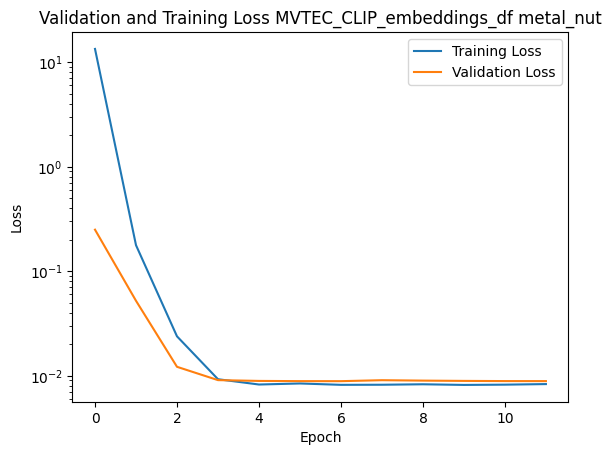

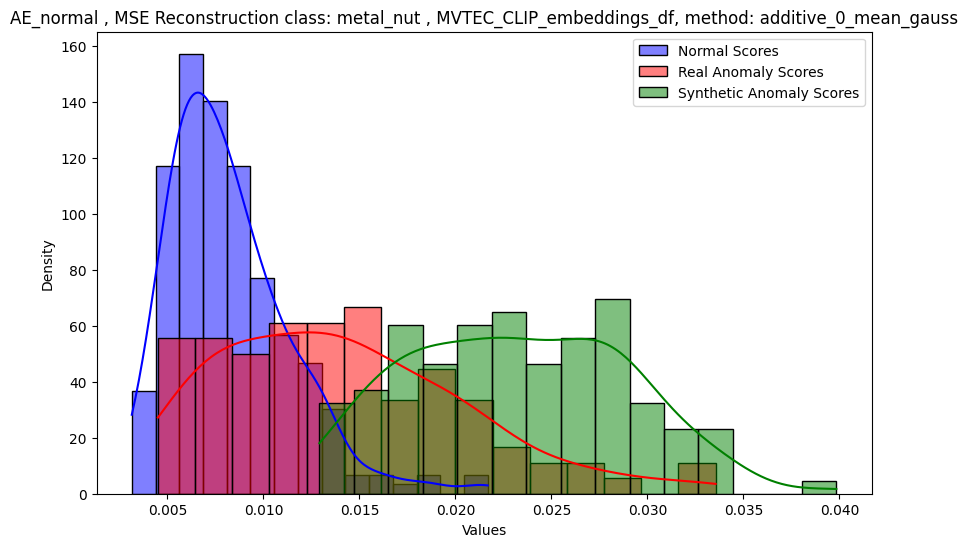

In [11]:
normal_data = torch.tensor(normals)
autoencoder_normal=train_autoencoder(normal_data, num_epochs=30,info=info)

normal_scores=np.mean((autoencoder_normal(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Real Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_normal , MSE Reconstruction class: {category} , {FILENAME}, method: {info["sampler"]}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

Epoch [1/30], Train Loss: 7.7790, Validation Loss: 0.0176
Epoch [2/30], Train Loss: 0.0167, Validation Loss: 0.0126
Epoch [3/30], Train Loss: 0.0095, Validation Loss: 0.0092
Epoch [4/30], Train Loss: 0.0085, Validation Loss: 0.0092
Epoch [5/30], Train Loss: 0.0086, Validation Loss: 0.0090
Epoch [6/30], Train Loss: 0.0083, Validation Loss: 0.0092
Epoch [7/30], Train Loss: 0.0086, Validation Loss: 0.0091
Epoch [8/30], Train Loss: 0.0086, Validation Loss: 0.0095
Epoch [9/30], Train Loss: 0.0086, Validation Loss: 0.0093
Epoch [10/30], Train Loss: 0.0085, Validation Loss: 0.0090
Epoch [11/30], Train Loss: 0.0086, Validation Loss: 0.0091
Epoch [12/30], Train Loss: 0.0085, Validation Loss: 0.0093
Epoch [13/30], Train Loss: 0.0085, Validation Loss: 0.0093
Epoch [14/30], Train Loss: 0.0085, Validation Loss: 0.0092
Epoch [15/30], Train Loss: 0.0087, Validation Loss: 0.0092
Early stopping triggered!


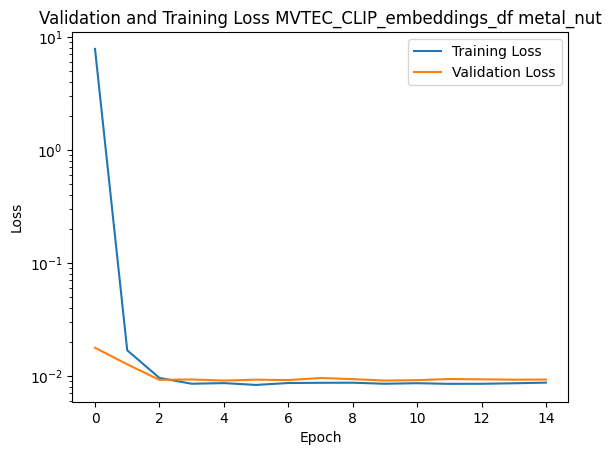

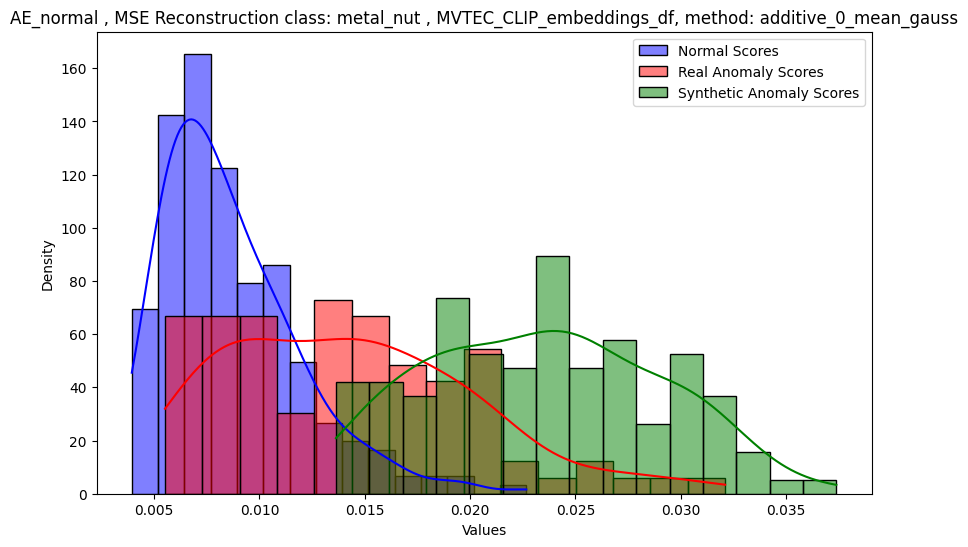

In [12]:
torch.cuda.empty_cache()
normal_data = torch.tensor(normals)

autoencoder_normal=train_autoencoder(normal_data, num_epochs=30,info=info)
normal_scores=np.mean((autoencoder_normal(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores=np.mean((autoencoder_normal(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores, label='Real Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_normal , MSE Reconstruction class: {category} , {FILENAME}, method: {info["sampler"]}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

### Train on synthetic data

Epoch [1/30], Train Loss: 25.0832, Validation Loss: 0.2170
Epoch [2/30], Train Loss: 0.1304, Validation Loss: 0.0896
Epoch [3/30], Train Loss: 0.0611, Validation Loss: 0.0444
Epoch [4/30], Train Loss: 0.0325, Validation Loss: 0.0271
Epoch [5/30], Train Loss: 0.0235, Validation Loss: 0.0248
Epoch [6/30], Train Loss: 0.0224, Validation Loss: 0.0222
Epoch [7/30], Train Loss: 0.0211, Validation Loss: 0.0224
Epoch [8/30], Train Loss: 0.0212, Validation Loss: 0.0221
Epoch [9/30], Train Loss: 0.0212, Validation Loss: 0.0223
Epoch [10/30], Train Loss: 0.0213, Validation Loss: 0.0220
Epoch [11/30], Train Loss: 0.0213, Validation Loss: 0.0221
Epoch [12/30], Train Loss: 0.0212, Validation Loss: 0.0219
Epoch [13/30], Train Loss: 0.0213, Validation Loss: 0.0223
Epoch [14/30], Train Loss: 0.0212, Validation Loss: 0.0224
Epoch [15/30], Train Loss: 0.0215, Validation Loss: 0.0233
Epoch [16/30], Train Loss: 0.0214, Validation Loss: 0.0230
Epoch [17/30], Train Loss: 0.0210, Validation Loss: 0.0227
Early

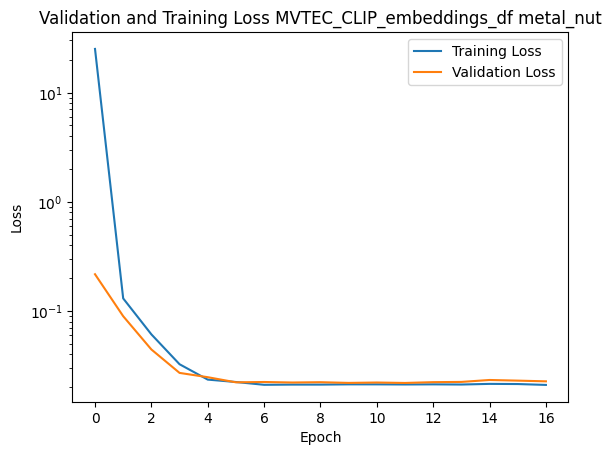

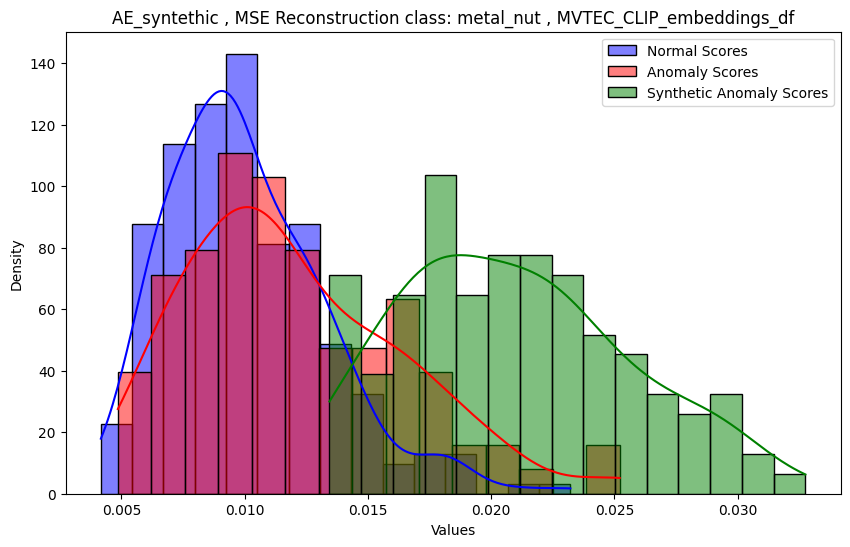

In [13]:
torch.cuda.empty_cache()
synthethicdata = torch.tensor(synthetic_anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(synthethicdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_syntethic , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()

### Train on anomalies

Epoch [1/30], Train Loss: 39.4777, Validation Loss: 0.1311
Epoch [2/30], Train Loss: 0.0913, Validation Loss: 0.0537
Epoch [3/30], Train Loss: 0.0346, Validation Loss: 0.0180
Epoch [4/30], Train Loss: 0.0166, Validation Loss: 0.0162
Epoch [5/30], Train Loss: 0.0142, Validation Loss: 0.0144
Epoch [6/30], Train Loss: 0.0130, Validation Loss: 0.0132
Epoch [7/30], Train Loss: 0.0126, Validation Loss: 0.0124
Epoch [8/30], Train Loss: 0.0120, Validation Loss: 0.0129
Epoch [9/30], Train Loss: 0.0120, Validation Loss: 0.0129
Epoch [10/30], Train Loss: 0.0118, Validation Loss: 0.0120
Epoch [11/30], Train Loss: 0.0125, Validation Loss: 0.0122
Epoch [12/30], Train Loss: 0.0121, Validation Loss: 0.0125
Epoch [13/30], Train Loss: 0.0120, Validation Loss: 0.0120
Epoch [14/30], Train Loss: 0.0117, Validation Loss: 0.0124
Epoch [15/30], Train Loss: 0.0118, Validation Loss: 0.0126
Early stopping triggered!


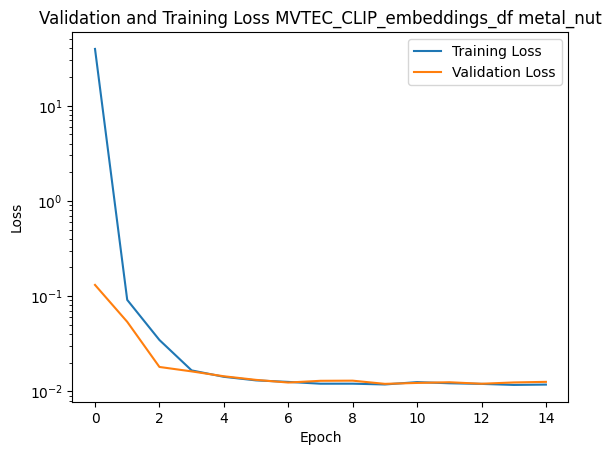

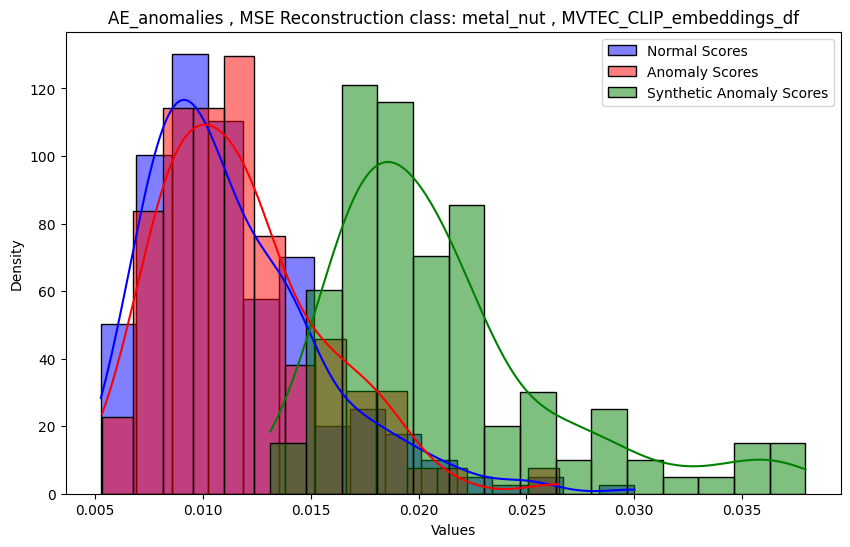

In [14]:
torch.cuda.empty_cache()
anomaliesdata = torch.tensor(anomalies) #anomalies or synthetic_anomalies
autoencoder_synthetic=train_autoencoder(anomaliesdata, num_epochs=30,info=info)

normal_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(normals).to(device))-torch.Tensor(normals).to(device)).cpu().detach().numpy()**2,1)
anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(anomalies).to(device))-torch.Tensor(anomalies).to(device)).cpu().detach().numpy()**2,1)
synthetic_anomaly_scores_np=np.mean((autoencoder_synthetic(torch.Tensor(synthetic_anomalies).to(device))-torch.Tensor(synthetic_anomalies).to(device)).cpu().detach().numpy()**2,1)

plt.figure(figsize=(10, 6))  
bins_number = 15  
sns.histplot(normal_scores_np, label='Normal Scores', kde=True, color='blue', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(anomaly_scores_np, label='Anomaly Scores', kde=True, color='red', stat="density", alpha=0.5, bins=bins_number)
sns.histplot(synthetic_anomaly_scores_np, label='Synthetic Anomaly Scores', kde=True, color='green', stat="density", alpha=0.5, bins=bins_number)
plt.title(f'AE_anomalies , MSE Reconstruction class: {category} , {FILENAME}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend() 
plt.show()